<a href="https://colab.research.google.com/github/priti378/earthquake_prediction/blob/main/EARTHQUAKE_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Earthquake prediction**

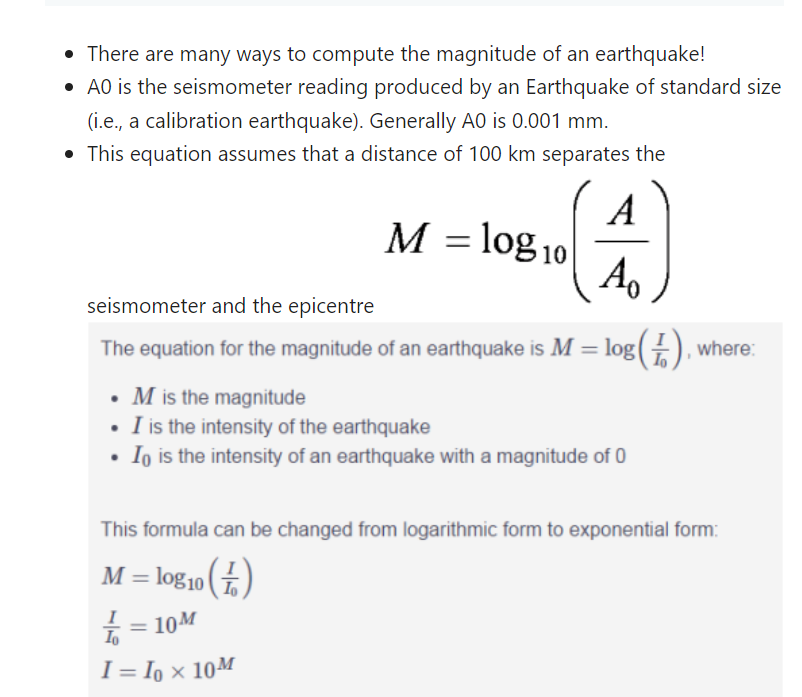

**Step 1 - Install & Import Dependencies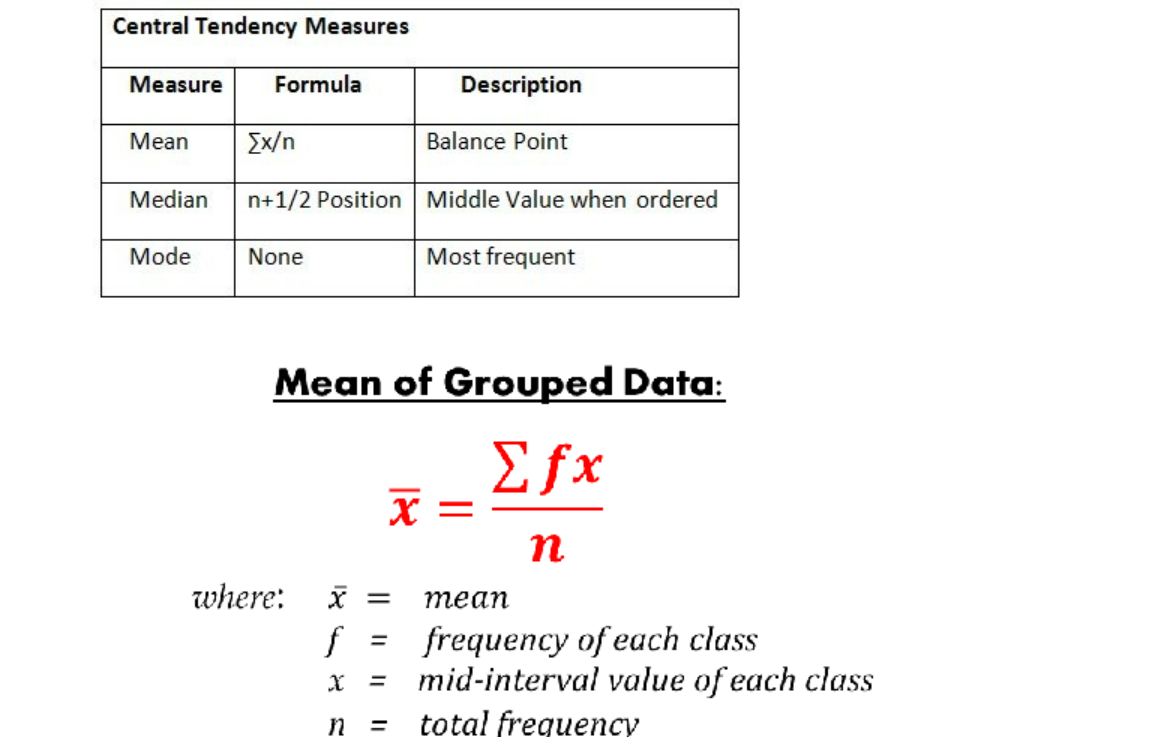**

In [ ]:
#to access kaggle datasets
!pip install kaggle
#Math operations
!pip install numpy==1.15.0
#Machine learning
!pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 28.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for numpy
  Running setup.py clean for numpy
  error: subprocess-exited-with-error
  
  × python setup.py clean did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed cleaning build dir for numpy
Failed to build numpy
ERROR: Could not build wheels for numpy, which is required to install pyproject.toml-based projects
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import time

import matplotlib.pyplot as plt


**Step 2 - Import Dataset from Kaggle**

In [ ]:
# Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [ ]:
#list competitions
!kaggle competitions list

ref                                                                                     deadline             category             reward  teamCount  userHasEntered  
--------------------------------------------------------------------------------------  -------------------  ---------------  ----------  ---------  --------------  
https://www.kaggle.com/competitions/arc-prize-2024                                      2024-11-10 23:59:00  Featured         $1,100,000        154           False  
https://www.kaggle.com/competitions/ai-mathematical-olympiad-prize                      2024-06-27 23:59:00  Featured         $1,048,576       1283           False  
https://www.kaggle.com/competitions/lmsys-chatbot-arena                                 2024-08-05 23:59:00  Research           $100,000        796           False  
https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2       2024-07-02 23:59:00  Featured            $50,000       2524           False  
http

In [ ]:
#download earthquake data, will take 30-60 seconds
!kaggle competitions download -c LANL-Earthquake-Prediction


100% 2.27G/2.27G [00:31<00:00, 100MB/s] 
100% 2.27G/2.27G [00:31<00:00, 78.3MB/s]


In [ ]:

#unzip training data for usage, will take about 5 minutes (its big)
!ls
!unzip LANL-Earthquake-Prediction.zip

LANL-Earthquake-Prediction.zip	sample_data
Archive:  LANL-Earthquake-Prediction.zip
  inflating: sample_submission.csv   
  inflating: test/seg_00030f.csv     
  inflating: test/seg_0012b5.csv     
  inflating: test/seg_00184e.csv     
  inflating: test/seg_003339.csv     
  inflating: test/seg_0042cc.csv     
  inflating: test/seg_004314.csv     
  inflating: test/seg_004cd2.csv     
  inflating: test/seg_004ee5.csv     
  inflating: test/seg_004f1f.csv     
  inflating: test/seg_00648a.csv     
  inflating: test/seg_006e4a.csv     
  inflating: test/seg_007a37.csv     
  inflating: test/seg_00a37e.csv     
  inflating: test/seg_00be11.csv     
  inflating: test/seg_00c35b.csv     
  inflating: test/seg_00cc91.csv     
  inflating: test/seg_00e5f7.csv     
  inflating: test/seg_00f3b9.csv     
  inflating: test/seg_010eab.csv     
  inflating: test/seg_0125d9.csv     
  inflating: test/seg_0144cb.csv     
  inflating: test/seg_0165c6.csv     
  inflating: test/seg_016913.csv     
  in

**Step 3 - Exploratory Data Analysis**

In [ ]:
!ls

LANL-Earthquake-Prediction.zip	sample_data  sample_submission.csv  test  train.csv


In [ ]:
#Extract training data into a dataframe for further manipulation
train = pd.read_csv('train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})


In [ ]:
#print first 10 entries
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


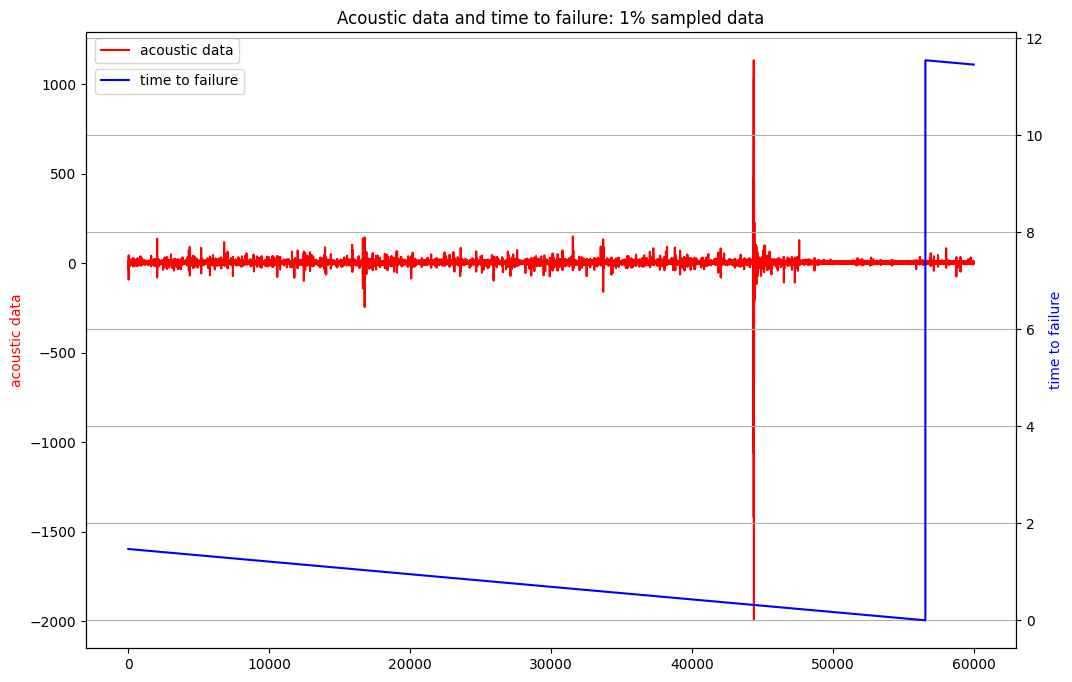

In [ ]:
#visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]
#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

**Step 4 - Feature Engineering**

In [ ]:
# Step 4 - Feature Engineering and signifiance of these statistical features

#lets create a function to generate some statistical features based on the training data
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)




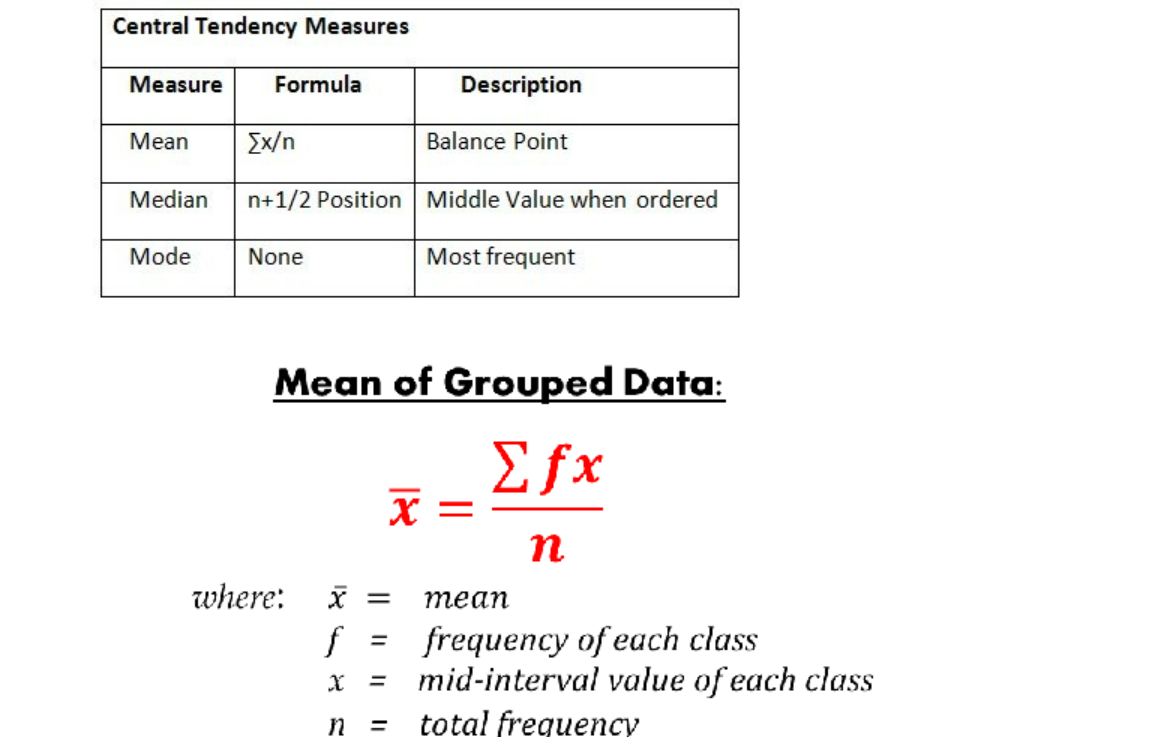

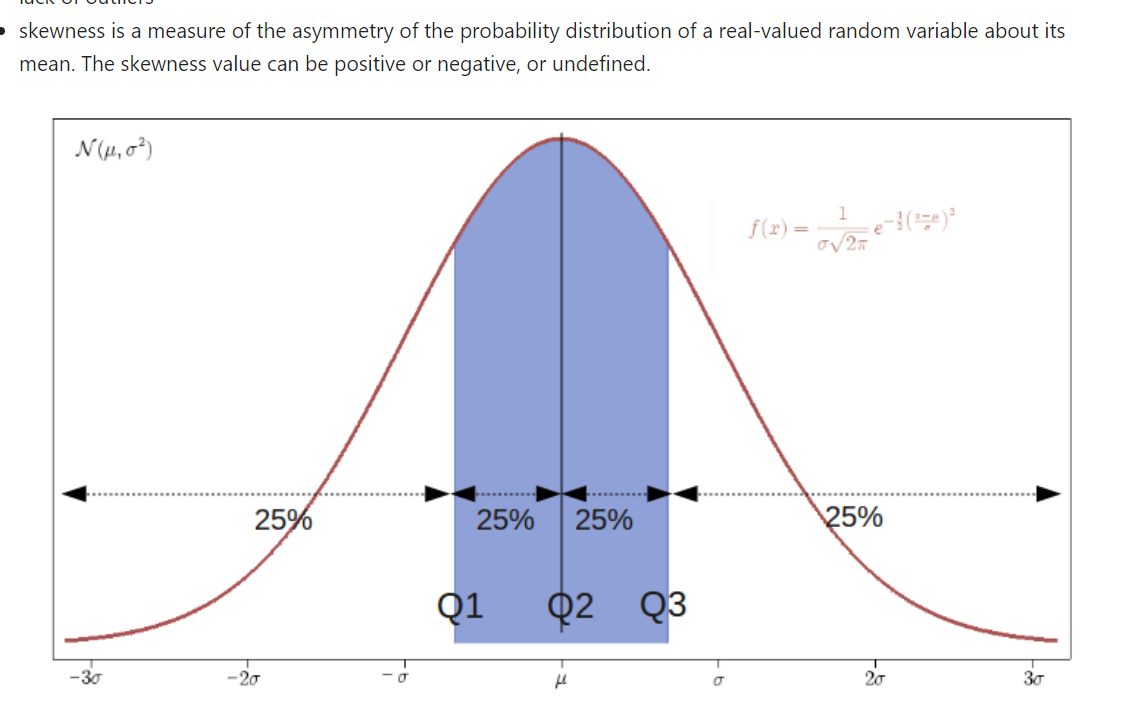

Quantiles are cut points dividing the range of a probability distribution into continuous intervals with equal probabilities, or dividing the observations in a sample in the same way.

In [ ]:
train = pd.read_csv('train.csv', iterator = True, chunksize = 150000,
                    dtype = {'acoustic_data': np.int16, 'time_to_failure': np.float64})  #Returns TextFileReader object for Iteration
X_train = pd.DataFrame()
y_train = pd.Series()
  ch = gen_features(df['acoustic_data'])
  X_train = pd.concat([X_train, ch], ignore_index=True)
  y_train = pd.concat([y_train, pd.Series([df['time_to_failure'].values[-1]])], ignore_index=True)
# Now X_train and y_train are ready for model training
X_train.describe()

,1,2
count,4195.000000,4195.000000
mean,4.519475,6.547788
std,0.256049,8.503939
min,3.596313,2.802720
25%,4.349497,4.478637
50%,4.522147,5.618798
75%,4.693350,6.880904
max,5.391993,153.703569


In [ ]:
X_train.describe()

,1,2
count,4195.000000,4195.000000
mean,4.519475,6.547788
std,0.256049,8.503939
min,3.596313,2.802720
25%,4.349497,4.478637
50%,4.522147,5.618798
75%,4.693350,6.880904
max,5.391993,153.703569


In [ ]:
y_train.describe()


count    4195.000000
mean        5.683670
std         3.673246
min         0.006398
25%         2.635348
50%         5.358796
75%         8.177500
max        16.103196
dtype: float64

In [ ]:
#Model #1 - Catboost

train_pool = Pool(X_train, y_train)
m = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
m.fit(X_train, y_train, silent=True)
m.best_score_

{'learn': {'MAE': 1.9248380631263793}}

In [ ]:
#Model #2 - Support Vector Machine w/ RBF + Grid Search

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)


Best CV score: -2.4896
{'C': 2, 'gamma': 0.1}
